# Importing Libraries

In [1]:
!pip install ../input/sacremoses/sacremoses-master/ > /dev/null

In [2]:
!pip install "../input/kerasswa/keras-swa-0.1.2"  > /dev/null

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import gc
import glob
import os
import sys
import string
import random
from tqdm import tqdm_notebook
from urllib.parse import urlparse
from sklearn.preprocessing import OneHotEncoder, minmax_scale, MultiLabelBinarizer
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import MultiTaskElasticNet
from scipy.stats import spearmanr, rankdata
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

#os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # -1 = CPU only

import nltk
from nltk.tag import pos_tag
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords

from gensim.models.doc2vec import TaggedDocument
from gensim import utils
import torch

sys.path.insert(0, "../input/transformers/transformers-master/")
import transformers


import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

import tensorflow_hub as hub

import keras
import keras.backend as K
from keras.layers import *
from keras.callbacks import *
from keras.optimizers import *
from keras import Model
from swa.keras import SWA

import lightgbm as lgb
import catboost as cb
import xgboost as xgb

import pickle    

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)                


Physical devices cannot be modified after being initialized


Using TensorFlow backend.


In [4]:
#INPUT_PATH="/kaggle/input/"
INPUT_PATH="../input/"
train = pd.read_csv(INPUT_PATH+'google-quest-challenge/train.csv')
test = pd.read_csv(INPUT_PATH+'google-quest-challenge/test.csv')
submission = pd.read_csv(INPUT_PATH+'google-quest-challenge/sample_submission.csv')

In [5]:
targets = [
        'question_asker_intent_understanding',
        'question_body_critical',
        'question_conversational',
        'question_expect_short_answer',
        'question_fact_seeking',
        'question_has_commonly_accepted_answer',
        'question_interestingness_others',
        'question_interestingness_self',
        'question_multi_intent',
        'question_not_really_a_question',
        'question_opinion_seeking',
        'question_type_choice',
        'question_type_compare',
        'question_type_consequence',
        'question_type_definition',
        'question_type_entity',
        'question_type_instructions',
        'question_type_procedure',
        'question_type_reason_explanation',
        'question_type_spelling',
        'question_well_written',
        'answer_helpful',
        'answer_level_of_information',
        'answer_plausible',
        'answer_relevance',
        'answer_satisfaction',
        'answer_type_instructions',
        'answer_type_procedure',
        'answer_type_reason_explanation',
        'answer_well_written'    
    ]

input_columns = ['question_title','question_body','answer']

In [6]:
#clean data
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', '\xa0', '\t',
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '\u3000', '\u202f',
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '«',
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

mispell_dict = {"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"couldnt" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"doesnt" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"havent" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"shouldnt" : "should not",
"that's" : "that is",
"thats" : "that is",
"there's" : "there is",
"theres" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"theyre":  "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"}


def clean_text(x):
    x = str(x).replace("\n","")
    for punct in puncts:
        x = x.replace(punct, f' {punct} ')
    return x


def clean_numbers(x):
    x = re.sub('[0-9]{5,}', '#####', x)
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)
    return x


def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re


def replace_typical_misspell(text):
    mispellings, mispellings_re = _get_mispell(mispell_dict)

    def replace(match):
        return mispellings[match.group(0)]

    return mispellings_re.sub(replace, text)


def clean_data(df, columns: list):
    for col in columns:
        df[col] = df[col].apply(lambda x: clean_numbers(x))
        df[col] = df[col].apply(lambda x: clean_text(x.lower()))
        df[col] = df[col].apply(lambda x: replace_typical_misspell(x))

    return df

In [7]:
train = clean_data(train, input_columns)
test = clean_data(test, input_columns)

In [8]:
train.head(3)

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0,what am i losing when using extension tubes in...,after playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"i just got extension tubes , so here ' s the ...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,...,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,0.000000,1.000000
1,1,what is the distinction between a city and a s...,i am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,it might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,...,0.888889,0.888889,0.555556,0.888889,0.888889,0.666667,0.0,0.000000,0.666667,0.888889
2,2,maximum protusion length for through - hole co...,i ' m working on a pcb that has through - hole...,Joe Baker,https://electronics.stackexchange.com/users/10157,do you even need grooves ? we make several p...,Dwayne Reid,https://electronics.stackexchange.com/users/64754,http://electronics.stackexchange.com/questions...,SCIENCE,...,0.777778,0.777778,0.555556,1.000000,1.000000,0.666667,0.0,0.333333,1.000000,0.888889


In [9]:
train['question_body'][0]

'after playing around with macro photography on - the - cheap  ( read :  reversed lens ,  rev .  lens mounted on a straight lens ,  passive extension tubes )  ,  i would like to get further with this .  the problems with the techniques i used is that focus is manual and aperture control is problematic at best .  this limited my setup to still subjects  ( read :  dead insects )  now ,  as spring is approaching ,  i want to be able to shoot live insects .  i believe that for this ,  autofocus and settable aperture will be of great help . so ,  one obvious but expensive option is a macro lens  ( say ,  ef  #  #  # mm macro )  however ,  i am not really interested in yet another prime lens .  an alternative is the electrical extension tubes . except for maximum focusing distance ,  what am i losing when using tubes  ( coupled with a fine lens ,  say ef #  #  -  #  #  #  / 2 . 8 )  instead of a macro lens ? '

In [10]:
from transformers import BertTokenizer, AdamW, BertModel, BertForSequenceClassification,BertPreTrainedModel, BertConfig 
from transformers import DistilBertConfig, DistilBertModel, DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer, RobertaForSequenceClassification

from transformers.optimization import get_linear_schedule_with_warmup

# Feature Engineering

In [11]:
# word count in title, body and answer
for colname in ['question_title', 'question_body', 'answer']:
    newname = colname + '_word_len'
    
    train[newname] = train[colname].str.split().str.len()
    test[newname] = test[colname].str.split().str.len()

    
del newname, colname

In [12]:
for colname in ['question', 'answer']:

    # check for nonames, i.e. users with logins like user12389
    train['is_'+colname+'_no_name_user'] = train[colname +'_user_name'].str.contains('^user\d+$') + 0
    test['is_'+colname+'_no_name_user'] = test[colname +'_user_name'].str.contains('^user\d+$') + 0
    

colname = 'answer'
# check lexical diversity (unique words count vs total )
train[colname+'_div'] = train[colname].apply(lambda s: len(set(s.split())) / len(s.split()) )
test[colname+'_div'] = test[colname].apply(lambda s: len(set(s.split())) / len(s.split()) )

In [13]:
train.head(2)

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,...,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written,question_title_word_len,question_body_word_len,answer_word_len,is_question_no_name_user,is_answer_no_name_user,answer_div
0,0,what am i losing when using extension tubes in...,after playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"i just got extension tubes , so here ' s the ...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,...,1.0,0.0,0.000000,1.000000,14,187,199,0,0,0.517588
1,1,what is the distinction between a city and a s...,i am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,it might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,...,0.0,0.0,0.666667,0.888889,22,179,94,0,0,0.712766


In [14]:
## domain components
train['domcom'] = train['question_user_page'].apply(lambda s: s.split('://')[1].split('/')[0].split('.'))
test['domcom'] = test['question_user_page'].apply(lambda s: s.split('://')[1].split('/')[0].split('.'))

# count components
train['dom_cnt'] = train['domcom'].apply(lambda s: len(s))
test['dom_cnt'] = test['domcom'].apply(lambda s: len(s))

# extend length
train['domcom'] = train['domcom'].apply(lambda s: s + ['none', 'none'])
test['domcom'] = test['domcom'].apply(lambda s: s + ['none', 'none'])

# components
for ii in range(0,4):
    train['dom_'+str(ii)] = train['domcom'].apply(lambda s: s[ii])
    test['dom_'+str(ii)] = test['domcom'].apply(lambda s: s[ii])
    
# clean up
train.drop('domcom', axis = 1, inplace = True)
test.drop('domcom', axis = 1, inplace = True)

In [15]:
import nltk
from nltk.corpus import stopwords
eng_stopwords = set(stopwords.words("english"))

# shared elements
train['q_words'] = train['question_body'].apply(lambda s: [f for f in s.split() if f not in eng_stopwords] )
train['a_words'] = train['answer'].apply(lambda s: [f for f in s.split() if f not in eng_stopwords] )
train['qa_word_overlap'] = train.apply(lambda s: len(np.intersect1d(s['q_words'], s['a_words'])), axis = 1)
train['qa_word_overlap_norm1'] = train.apply(lambda s: s['qa_word_overlap']/(1 + len(s['a_words'])), axis = 1)
train['qa_word_overlap_norm2'] = train.apply(lambda s: s['qa_word_overlap']/(1 + len(s['q_words'])), axis = 1)
train.drop(['q_words', 'a_words'], axis = 1, inplace = True)

test['q_words'] = test['question_body'].apply(lambda s: [f for f in s.split() if f not in eng_stopwords] )
test['a_words'] = test['answer'].apply(lambda s: [f for f in s.split() if f not in eng_stopwords] )
test['qa_word_overlap'] = test.apply(lambda s: len(np.intersect1d(s['q_words'], s['a_words'])), axis = 1)
test['qa_word_overlap_norm1'] = test.apply(lambda s: s['qa_word_overlap']/(1 + len(s['a_words'])), axis = 1)
test['qa_word_overlap_norm2'] = test.apply(lambda s: s['qa_word_overlap']/(1 + len(s['q_words'])), axis = 1)
test.drop(['q_words', 'a_words'], axis = 1, inplace = True)

In [16]:
## Number of characters in the text ##
train["question_title_num_chars"] = train["question_title"].apply(lambda x: len(str(x)))
test["question_title_num_chars"] = test["question_title"].apply(lambda x: len(str(x)))
train["question_body_num_chars"] = train["question_body"].apply(lambda x: len(str(x)))
test["question_body_num_chars"] = test["question_body"].apply(lambda x: len(str(x)))
train["answer_num_chars"] = train["answer"].apply(lambda x: len(str(x)))
test["answer_num_chars"] = test["answer"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
train["question_title_num_stopwords"] = train["question_title"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
test["question_title_num_stopwords"] = test["question_title"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
train["question_body_num_stopwords"] = train["question_body"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
test["question_body_num_stopwords"] = test["question_body"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
train["answer_num_stopwords"] = train["answer"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
test["answer_num_stopwords"] = test["answer"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

## Number of punctuations in the text ##
train["question_title_num_punctuations"] =train['question_title'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test["question_title_num_punctuations"] =test['question_title'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
train["question_body_num_punctuations"] =train['question_body'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test["question_body_num_punctuations"] =test['question_body'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
train["answer_num_punctuations"] =train['answer'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test["answer_num_punctuations"] =test['answer'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the text ##
train["question_title_num_words_upper"] = train["question_title"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test["question_title_num_words_upper"] = test["question_title"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
train["question_body_num_words_upper"] = train["question_body"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test["question_body_num_words_upper"] = test["question_body"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
train["answer_num_words_upper"] = train["answer"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test["answer_num_words_upper"] = test["answer"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

In [17]:
list(train.columns)

['qa_id',
 'question_title',
 'question_body',
 'question_user_name',
 'question_user_page',
 'answer',
 'answer_user_name',
 'answer_user_page',
 'url',
 'category',
 'host',
 'question_asker_intent_understanding',
 'question_body_critical',
 'question_conversational',
 'question_expect_short_answer',
 'question_fact_seeking',
 'question_has_commonly_accepted_answer',
 'question_interestingness_others',
 'question_interestingness_self',
 'question_multi_intent',
 'question_not_really_a_question',
 'question_opinion_seeking',
 'question_type_choice',
 'question_type_compare',
 'question_type_consequence',
 'question_type_definition',
 'question_type_entity',
 'question_type_instructions',
 'question_type_procedure',
 'question_type_reason_explanation',
 'question_type_spelling',
 'question_well_written',
 'answer_helpful',
 'answer_level_of_information',
 'answer_plausible',
 'answer_relevance',
 'answer_satisfaction',
 'answer_type_instructions',
 'answer_type_procedure',
 'answer_typ

In [18]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [19]:
train.head(4)

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written,question_title_word_len,question_body_word_len,answer_word_len,is_question_no_name_user,is_answer_no_name_user,answer_div,dom_cnt,dom_0,dom_1,dom_2,dom_3,qa_word_overlap,qa_word_overlap_norm1,qa_word_overlap_norm2,question_title_num_chars,question_body_num_chars,answer_num_chars,question_title_num_stopwords,question_body_num_stopwords,answer_num_stopwords,question_title_num_punctuations,question_body_num_punctuations,answer_num_punctuations,question_title_num_words_upper,question_body_num_words_upper,answer_num_words_upper
0,0,what am i losing when using extension tubes in...,after playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"i just got extension tubes , so here ' s the ...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,photo.stackexchange.com,1.000000,0.333333,0.000000,0.0,0.0,0.0,1.000000,1.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.000000,0.000000,0.0,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,0.000000,1.000000,14,187,199,0,0,0.517588,3,photo,stackexchange,com,none,21,0.169355,0.162791,70,915,906,6,59,76,1,42,44,0,0,0
1,1,what is the distinction between a city and a s...,i am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,it might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,rpg.stackexchange.com,1.000000,1.000000,0.000000,0.5,1.0,1.0,0.444444,0.444444,0.666667,0.0,0.000000,0.666667,0.666667,0.0,0.333333,0.0,0.0,0.000000,0.333333,0.0,0.888889,0.888889,0.555556,0.888889,0.888889,0.666667,0.0,0.000000,0.666667,0.888889,22,179,94,0,0,0.712766,3,rpg,stackexchange,com,none,16,0.246154,0.137931,118,862,480,10,64,30,5,38,17,0,0,0
2,2,maximum protusion length for through - hole co...,i ' m working on a pcb that has through - hole...,Joe Baker,https://electronics.stackexchange.com/users/10157,do you even need grooves ? we make several p...,Dwayne Reid,https://electronics.stackexchange.com/users/64754,http://electronics.stackexchange.com/questions...,SCIENCE,electronics.stackexchange.com,0.888889,0.666667,0.000000,1.0,1.0,1.0,0.666667,0.444444,0.333333,0.0,0.333333,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.333333,0.333333,0.0,0.777778,0.777778,0.555556,1.000000,1.000000,0.666667,0.0,0.333333,1.000000,0.888889,9,150,216,0,0,0.569444,3,electronics,stackexchange,com,none,19,0.145038,0.206522,58,700,1091,2,59,86,1,25,26,0,0,0
3,3,can an affidavit be used in beit din ?,"an affidavit , from what i understand , is b...",Scimonster,https://judaism.stackexchange.com/users/5151,"sending an "" affidavit "" it is a dispute bet...",Y e z,https://judaism.stackexchange.com/users/4794,http://judaism.stackexchange.com/questions/551...,CULTURE,judaism.stackexchange.com,0.888889,0.666667,0.666667,1.0,1.0,1.0,0.444444,0.444444,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.888889,0.833333,0.333333,0.833333,1.000000,0.800000,0.0,0.00

In [20]:
cont_cols = [
'question_title_word_len',
'question_body_word_len',
'answer_div',
'answer_word_len',
'qa_word_overlap',
 'qa_word_overlap_norm1',
 'qa_word_overlap_norm2',
 'question_title_num_chars',
 'question_body_num_chars',
 'answer_num_chars',
 
   
]

cat_cols = [
 'is_question_no_name_user',
 'is_answer_no_name_user',    
'dom_cnt',
 'dom_0',
 'dom_1',
 'dom_2',
 'dom_3', 
'question_title_num_stopwords',
 'question_body_num_stopwords',
 'answer_num_stopwords',
 'question_title_num_punctuations',
 'question_body_num_punctuations',
 'answer_num_punctuations',
 'question_title_num_words_upper',
 'question_body_num_words_upper',
 'answer_num_words_upper'
        
]

In [21]:
train.shape[1] == len(cat_cols+cont_cols+targets+input_columns)+8

True

# BERT Embeddings

In [22]:
#bert embedings
try:
    pbe = load_obj("../input/questembeddings/precomputed_bert_embeddings")
    train_question_body_dense = pbe['train_question_body_dense']
    train_answer_dense = pbe['train_answer_dense']
    train_question_title_dense = pbe['train_question_title_dense']
    test_question_body_dense = pbe['test_question_body_dense']
    test_answer_dense = pbe['test_answer_dense']
    test_question_title_dense = pbe['test_question_title_dense']
except:
    print("Load failed, build embedding")
    def sigmoid(x):
        return 1 / (1 + math.exp(-x))

    def chunks(l, n):
        """Yield successive n-sized chunks from l."""
        for i in range(0, len(l), n):
            yield l[i:i + n]

    def fetch_vectors(string_list, batch_size=64):
        
        DEVICE = torch.device("cuda")
        tokenizer = transformers.DistilBertTokenizer.from_pretrained("../input/distilbertbaseuncased/")
        model = transformers.DistilBertModel.from_pretrained("../input/distilbertbaseuncased/")
        model.to(DEVICE)
        # inspired by https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/
#         DEVICE = torch.device("cuda")
#         tokenizer = transformers.BertTokenizer.from_pretrained("../input/pretrained-bert-models-for-pytorch/bert-base-uncased-vocab.txt")
#         bert_config = BertConfig.from_json_file('../input/pretrained-bert-models-for-pytorch/bert-base-uncased/bert_config.json')
#         bert_config.num_labels =30

#         model_path = os.path.join('../input/pretrained-bert-models-for-pytorch/bert-base-uncased/')

#         model = BertModel.from_pretrained(model_path, config=bert_config)
#         model.to(DEVICE)

            

        fin_features = []
        for data in tqdm_notebook(chunks(string_list, batch_size)):
            tokenized = []
            for x in data:
                x = " ".join(x.strip().split()[:300])
                tok = tokenizer.encode(x, add_special_tokens=True)
                tokenized.append(tok[:512])

            max_len = 512
            padded = np.array([i + [0] * (max_len - len(i)) for i in tokenized], dtype='int64')
            attention_mask = np.where(padded != 0, 1, 0)
            input_ids = torch.tensor(padded).to(DEVICE)
            attention_mask = torch.tensor(attention_mask).to(DEVICE)

            with torch.no_grad():
                last_hidden_states = model(input_ids, attention_mask=attention_mask)

            features = last_hidden_states[0][:, 0, :].cpu().numpy()
            fin_features.append(features)

        fin_features = np.vstack(fin_features)
        return fin_features

    train_question_body_dense = fetch_vectors(train.question_body.values)
    train_answer_dense = fetch_vectors(train.answer.values)
    train_question_title_dense = fetch_vectors(train.question_title.values)


    test_question_body_dense = fetch_vectors(test.question_body.values)
    test_answer_dense = fetch_vectors(test.answer.values)
    test_question_title_dense = fetch_vectors(test.question_title.values)

    precomputed_bert_embeddings = {
        'train_question_body_dense': train_question_body_dense,
        'train_answer_dense': train_answer_dense,
        'train_question_title_dense': train_question_title_dense,
        'test_question_body_dense': test_question_body_dense,
        'test_answer_dense': test_answer_dense,
        'test_question_title_dense': test_question_title_dense,

    }

    #save_obj(precomputed_bert_embeddings,"../input/questembeddings/precomputed_bert_embeddings")

Load failed, build embedding


# TFIDF Embeddings

In [23]:
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import scipy
from sklearn.metrics import log_loss
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import hstack
from sklearn.decomposition import TruncatedSVD

train_text_1 = train['question_body']
test_text_1 = test['question_body']
all_text_1 = pd.concat([train_text_1, test_text_1])

train_text_2 = train['answer']
test_text_2 = test['answer']
all_text_2 = pd.concat([train_text_2, test_text_2])

train_text_3 = train['question_title']
test_text_3 = test['question_title']
all_text_3 = pd.concat([train_text_3, test_text_3])

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 2),
    max_features=80000,
    tokenizer=tokenize)
word_vectorizer.fit(all_text_1)

train_word_features_1 = word_vectorizer.transform(train_text_1)
test_word_features_1 = word_vectorizer.transform(test_text_1)

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 2),
    max_features=80000,
    tokenizer=tokenize)
word_vectorizer.fit(all_text_2)

train_word_features_2 = word_vectorizer.transform(train_text_2)
test_word_features_2 = word_vectorizer.transform(test_text_2)

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 2),
    max_features=80000,
    tokenizer=tokenize)
word_vectorizer.fit(all_text_3)

train_word_features_3 = word_vectorizer.transform(train_text_3)
test_word_features_3 = word_vectorizer.transform(test_text_3)

char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    token_pattern=r'\w{1,}',
    ngram_range=(1, 4),
    max_features=50000,
    tokenizer=tokenize)
char_vectorizer.fit(all_text_1)

train_char_features_1 = char_vectorizer.transform(train_text_1)
test_char_features_1 = char_vectorizer.transform(test_text_1)

char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    token_pattern=r'\w{1,}',
    ngram_range=(1, 4),
    max_features=50000,
    tokenizer=tokenize)
char_vectorizer.fit(all_text_2)

train_char_features_2 = char_vectorizer.transform(train_text_2)
test_char_features_2 = char_vectorizer.transform(test_text_2)

char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    ngram_range=(1, 4),
    max_features=50000,
    tokenizer=tokenize)
char_vectorizer.fit(all_text_3)

train_char_features_3 = char_vectorizer.transform(train_text_3)
test_char_features_3 = char_vectorizer.transform(test_text_3)

train_features_tfidf = hstack([train_char_features_1, train_word_features_1, train_char_features_2, train_word_features_2,train_char_features_3, train_word_features_3])
test_features_tfidf = hstack([test_char_features_1, test_word_features_1, test_char_features_2, test_word_features_2,test_char_features_3, test_word_features_3])

pca = TruncatedSVD(n_components=128, n_iter=10)
tf_idf_text_train = pca.fit_transform(train_features_tfidf)
tf_idf_text_test = pca.fit_transform(test_features_tfidf)

In [25]:
tf_idf_text_train.shape, tf_idf_text_test.shape

((6079, 128), (476, 128))

In [26]:
torch.cuda.empty_cache() # release all gpu memory from pytorch

# Universal Sentence Encoder embeddings

In [27]:
# universal sentence encoder

try:
    embeddings_train = load_obj("../input/questembeddings/use_embeddings_train")
    embeddings_test = load_obj("../input/questembeddings/use_embeddings_test")
except:
    print("Load failed, build embedding")
    try:
        module_url = INPUT_PATH+'universalsentenceencoderlarge4/'
        embed = hub.load(module_url)
        def UniversalEmbedding(x):
            results = embed(tf.squeeze(tf.cast(x, tf.string)))["outputs"]
            return keras.backend.concatenate([results])
    except:
        module_url = INPUT_PATH+'universalsentenceencoderlarge3/'
        embed = hub.Module(module_url)
        def UniversalEmbedding(x):
            results = embed(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]
            return keras.backend.concatenate([results])

    embeddings_train = {}
    embeddings_test = {}
    for text in input_columns:
        print(text)
        train_text = train[text].str.replace('?', '.').str.replace('!', '.').tolist()
        test_text = test[text].str.replace('?', '.').str.replace('!', '.').tolist()

        curr_train_emb = []
        curr_test_emb = []
        batch_size = 4
        ind = 0
        while ind*batch_size < len(train_text):
            curr_train_emb.append(embed(train_text[ind*batch_size: (ind + 1)*batch_size])["outputs"].numpy())
            ind += 1

        ind = 0
        while ind*batch_size < len(test_text):
            curr_test_emb.append(embed(test_text[ind*batch_size: (ind + 1)*batch_size])["outputs"].numpy())
            ind += 1    

        embeddings_train[text + '_embedding'] = np.vstack(curr_train_emb)
        embeddings_test[text + '_embedding'] = np.vstack(curr_test_emb)

    del embed
    K.clear_session()
    gc.collect()
    
    #save_obj(embeddings_train,"../input/questembeddings/use_embeddings_train")
    #save_obj(embeddings_test,"../input/questembeddings/use_embeddings_test")

Load failed, build embedding
question_title
question_body
answer


In [28]:
embeddings_train

{'question_title_embedding': array([[ 0.06080656,  0.03104777,  0.02927576, ..., -0.00650984,
         -0.01837468,  0.02125643],
        [ 0.07717127, -0.04670992, -0.00901496, ..., -0.03333262,
         -0.03291266, -0.03456048],
        [-0.03269646,  0.00624057,  0.0003352 , ...,  0.01786818,
          0.0957114 , -0.01346991],
        ...,
        [-0.00367079,  0.03932334,  0.01786841, ...,  0.02404222,
          0.02099693, -0.026074  ],
        [-0.09923364,  0.0067908 ,  0.03075409, ...,  0.04084375,
         -0.04759604,  0.06225646],
        [ 0.0235627 , -0.04136239,  0.00439787, ...,  0.05472193,
          0.02762538,  0.03841458]], dtype=float32),
 'question_body_embedding': array([[ 0.07309183, -0.01580983,  0.07910844, ..., -0.00760685,
          0.03956527,  0.05418975],
        [ 0.05686731, -0.007254  ,  0.00685255, ..., -0.04743896,
         -0.02482959, -0.04625017],
        [-0.00802972,  0.04002437,  0.00349687, ...,  0.03197649,
         -0.01077706,  0.04481924

In [29]:
find = re.compile(r"^[^.]*")
train['netloc_1'] = train['url'].apply(lambda x: re.findall(find, urlparse(x).netloc)[0])
test['netloc_1'] = test['url'].apply(lambda x: re.findall(find, urlparse(x).netloc)[0])

train['netloc_2'] = train['question_user_page'].apply(lambda x: re.findall(find, urlparse(x).netloc)[0])
test['netloc_2'] = test['question_user_page'].apply(lambda x: re.findall(find, urlparse(x).netloc)[0])

train['netloc_3'] = train['answer_user_page'].apply(lambda x: re.findall(find, urlparse(x).netloc)[0])
test['netloc_3'] = test['answer_user_page'].apply(lambda x: re.findall(find, urlparse(x).netloc)[0])

tabular_cols = ['question_user_name', 'answer_user_name', 
               'netloc_1', 'netloc_2', 'netloc_3',
               'category', 'host']


    
l2_dist = lambda x, y: np.power(x - y, 2).sum(axis=1)
cos_dist = lambda x, y: (x*y).sum(axis=1)
abs_dist = lambda x, y: np.abs(x-y).sum(axis=1)
sum_dist = lambda x, y: (x+y).sum(axis=1)

dist_features_train = np.array([
    l2_dist(embeddings_train['question_title_embedding'], embeddings_train['answer_embedding']),
    l2_dist(embeddings_train['question_body_embedding'], embeddings_train['answer_embedding']),
    l2_dist(embeddings_train['question_body_embedding'], embeddings_train['question_title_embedding']),

    cos_dist(embeddings_train['question_title_embedding'], embeddings_train['answer_embedding']),
    cos_dist(embeddings_train['question_body_embedding'], embeddings_train['answer_embedding']),
    cos_dist(embeddings_train['question_body_embedding'], embeddings_train['question_title_embedding']),
    
    abs_dist(embeddings_train['question_title_embedding'], embeddings_train['answer_embedding']),
    abs_dist(embeddings_train['question_body_embedding'], embeddings_train['answer_embedding']),
    abs_dist(embeddings_train['question_body_embedding'], embeddings_train['question_title_embedding']),
  
    sum_dist(embeddings_train['question_title_embedding'], embeddings_train['answer_embedding']),
    sum_dist(embeddings_train['question_body_embedding'], embeddings_train['answer_embedding']),
    sum_dist(embeddings_train['question_body_embedding'], embeddings_train['question_title_embedding']),

    l2_dist(train_question_body_dense, train_answer_dense),
    cos_dist(train_question_body_dense, train_answer_dense),
    abs_dist(train_question_body_dense, train_answer_dense),
    sum_dist(train_question_body_dense, train_answer_dense),
    
    l2_dist(train_question_body_dense, train_question_title_dense),
    cos_dist(train_question_body_dense, train_question_title_dense),
    abs_dist(train_question_body_dense, train_question_title_dense),
    sum_dist(train_question_body_dense, train_question_title_dense),
    
    l2_dist(train_answer_dense, train_question_title_dense),
    cos_dist(train_answer_dense, train_question_title_dense),
    abs_dist(train_answer_dense, train_question_title_dense),
    sum_dist(train_answer_dense, train_question_title_dense),
]).T


dist_features_test = np.array([
    l2_dist(embeddings_test['question_title_embedding'], embeddings_test['answer_embedding']),
    l2_dist(embeddings_test['question_body_embedding'], embeddings_test['answer_embedding']),
    l2_dist(embeddings_test['question_body_embedding'], embeddings_test['question_title_embedding']),
    
    
    cos_dist(embeddings_test['question_title_embedding'], embeddings_test['answer_embedding']),
    cos_dist(embeddings_test['question_body_embedding'], embeddings_test['answer_embedding']),
    cos_dist(embeddings_test['question_body_embedding'], embeddings_test['question_title_embedding']),
   
    
    abs_dist(embeddings_test['question_title_embedding'], embeddings_test['answer_embedding']),
    abs_dist(embeddings_test['question_body_embedding'], embeddings_test['answer_embedding']),
    abs_dist(embeddings_test['question_body_embedding'], embeddings_test['question_title_embedding']),

    
    sum_dist(embeddings_test['question_title_embedding'], embeddings_test['answer_embedding']),
    sum_dist(embeddings_test['question_body_embedding'], embeddings_test['answer_embedding']),
    sum_dist(embeddings_test['question_body_embedding'], embeddings_test['question_title_embedding']),

    
    l2_dist(test_question_body_dense, test_answer_dense),
    cos_dist(test_question_body_dense, test_answer_dense),
    abs_dist(test_question_body_dense, test_answer_dense),
    sum_dist(test_question_body_dense, test_answer_dense),
    
    l2_dist(test_question_body_dense, test_question_title_dense),
    cos_dist(test_question_body_dense, test_question_title_dense),
    abs_dist(test_question_body_dense, test_question_title_dense),
    sum_dist(test_question_body_dense, test_question_title_dense),
    
    l2_dist(test_answer_dense, test_question_title_dense),
    cos_dist(test_answer_dense, test_question_title_dense),
    abs_dist(test_answer_dense, test_question_title_dense),
    sum_dist(test_answer_dense, test_question_title_dense),
]).T

In [30]:
dist_features_train.shape, tf_idf_text_train.shape

((6079, 24), (6079, 128))

In [31]:
for k, item in embeddings_train.items():
    print(len(item))

6079
6079
6079


In [32]:
train_question_body_dense.shape, train_answer_dense.shape

((6079, 768), (6079, 768))

In [33]:
possible_features_train = [
    [item for k, item in embeddings_train.items()],
    [ dist_features_train ],
    [ train_question_body_dense ],
    [ train_answer_dense ],
    
    [ tf_idf_text_train ]
    
]
possible_features_test = [
    [item for k, item in embeddings_test.items()],
    [ dist_features_test ],
    [ test_question_body_dense ],
    [ test_answer_dense ],
    
    [ tf_idf_text_test ]
]

def get_train_test(split=0.8):
    total_len = len(possible_features_train)
    r_idx = random.sample(range(total_len), int(total_len * split))
    
    train = [ train_question_title_dense ]

    test =  [ test_question_title_dense ]

    for i in r_idx:
        train += possible_features_train[i]
        test += possible_features_test[i]
        
    return np.hstack(train),np.hstack(test)

X_train,X_test = get_train_test()
y_train = train[targets].values

In [34]:
X_train.shape, X_test.shape

((6079, 3224), (476, 3224))

In [35]:
X_train = pd.DataFrame(data = X_train)
X_train.columns = [str(col) + '_col' for col in X_train.columns]

X_test = pd.DataFrame(data=X_test)
X_test.columns = [str(col) + '_col' for col in X_test.columns]

In [36]:
train[tabular_cols].head()

,question_user_name,answer_user_name,netloc_1,netloc_2,netloc_3,category,host
0,ysap,rfusca,photo,photo,photo,LIFE_ARTS,photo.stackexchange.com
1,russellpierce,Erik Schmidt,rpg,rpg,rpg,CULTURE,rpg.stackexchange.com
2,Joe Baker,Dwayne Reid,electronics,electronics,electronics,SCIENCE,electronics.stackexchange.com
3,Scimonster,Y e z,judaism,judaism,judaism,CULTURE,judaism.stackexchange.com
4,leigero,q2ra,graphicdesign,graphicdesign,graphicdesign,LIFE_ARTS,graphicdesign.stackexchange.com


In [37]:
pd_concat_train = [X_train, train[targets], train[tabular_cols], train[cat_cols], train[cont_cols]]
pd_concat_test = [X_test, test[tabular_cols], test[cat_cols], test[cont_cols]]


final_train_df = pd.concat(pd_concat_train, axis=1)
final_test_df = pd.concat(pd_concat_test, axis=1)

In [38]:
final_train_df.shape, final_test_df.shape

((6079, 3287), (476, 3257))

In [39]:
valid_sz = 1000
valid_idx = range(len(final_train_df)-valid_sz, len(final_train_df))
valid_idx

range(5079, 6079)

In [40]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.text import *
from fastai.tabular import *

from pathlib import Path
from typing import *

import torch
import torch.optim as optim

from scipy.special import erfinv
import matplotlib.pyplot as plt
import torch
from torch.utils.data import *
from torch.optim import *
from fastai.tabular import *
import torch.utils.data as Data
from fastai.basics import *
from fastai.callbacks.hooks import *
from tqdm import tqdm_notebook as tqdm

In [41]:
def to_gauss(x): return np.sqrt(2)*erfinv(x)  #from scipy

def normalize(data, exclude=None):
    # if not binary, normalize it
    norm_cols = [n for n, c in data.drop(exclude, 1).items() if len(np.unique(c)) > 2]
    n = data.shape[0]
    for col in norm_cols:
        sorted_idx = data[col].sort_values().index.tolist()# list of sorted index
        uniform = np.linspace(start=-0.99, stop=0.99, num=n) # linsapce
        normal = to_gauss(uniform) # apply gauss to linspace
        normalized_col = pd.Series(index=sorted_idx, data=normal) # sorted idx and normalized space
        data[col] = normalized_col # column receives its corresponding rank
    return data

In [42]:
list(final_train_df[tabular_cols+targets+cat_cols].columns)

['question_user_name',
 'answer_user_name',
 'netloc_1',
 'netloc_2',
 'netloc_3',
 'category',
 'host',
 'question_asker_intent_understanding',
 'question_body_critical',
 'question_conversational',
 'question_expect_short_answer',
 'question_fact_seeking',
 'question_has_commonly_accepted_answer',
 'question_interestingness_others',
 'question_interestingness_self',
 'question_multi_intent',
 'question_not_really_a_question',
 'question_opinion_seeking',
 'question_type_choice',
 'question_type_compare',
 'question_type_consequence',
 'question_type_definition',
 'question_type_entity',
 'question_type_instructions',
 'question_type_procedure',
 'question_type_reason_explanation',
 'question_type_spelling',
 'question_well_written',
 'answer_helpful',
 'answer_level_of_information',
 'answer_plausible',
 'answer_relevance',
 'answer_satisfaction',
 'answer_type_instructions',
 'answer_type_procedure',
 'answer_type_reason_explanation',
 'answer_well_written',
 'is_question_no_name_us

In [43]:
exclude = list(final_train_df[tabular_cols+targets+cat_cols].columns)
norm_data_train = normalize(final_train_df, exclude=exclude)

exclude = list(final_test_df[tabular_cols+cat_cols].columns)
norm_data_test = normalize(final_test_df, exclude=exclude)

In [44]:
gc.collect()

4

In [45]:
tabular_cols+cat_cols

['question_user_name',
 'answer_user_name',
 'netloc_1',
 'netloc_2',
 'netloc_3',
 'category',
 'host',
 'is_question_no_name_user',
 'is_answer_no_name_user',
 'dom_cnt',
 'dom_0',
 'dom_1',
 'dom_2',
 'dom_3',
 'question_title_num_stopwords',
 'question_body_num_stopwords',
 'answer_num_stopwords',
 'question_title_num_punctuations',
 'question_body_num_punctuations',
 'answer_num_punctuations',
 'question_title_num_words_upper',
 'question_body_num_words_upper',
 'answer_num_words_upper']

In [46]:
cont_names = list(X_train.columns)+cont_cols
cat_names = tabular_cols+cat_cols
dep_var = targets
procs = [FillMissing, Categorify]

test_tab = TabularList.from_df(norm_data_test, cat_names=cat_names, cont_names=cont_names, procs=procs)

data = (TabularList.from_df(norm_data_train, procs = procs, cont_names=cont_names, cat_names=cat_names)
        .split_by_idx(valid_idx)
        .label_from_df(cols=dep_var)
        .add_test(test_tab)
        .databunch(bs=32))

In [47]:
data.show_batch()

In [48]:
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.style as style
style.use('seaborn-poster')
style.use('ggplot')

In [49]:
def _get_ranks(arr: np.ndarray) -> np.ndarray:
    """
        Efficiently calculates the ranks of the data.
        Only sorts once to get the ranked data.
        
        :param arr: A 1D NumPy Array
        :return: A 1D NumPy Array containing the ranks of the data
    """
    temp = arr.argsort()
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(arr))
    return ranks

In [50]:
def spearmans_rho_custom(y_true: np.ndarray, y_pred: np.ndarray) -> np.float64:
    """
        Efficiently calculates the Spearman's Rho correlation using only NumPy
        
        :param y_true: The ground truth labels
        :param y_pred: The predicted labels
    """
    # Get ranked data
    true_rank = _get_ranks(y_true)
    pred_rank = _get_ranks(y_pred)
    
    cost = np.corrcoef(true_rank, pred_rank)[1][0]
    loss = cost.mean()
    loss = loss*(-1)
    return loss

In [51]:
class Regress_Loss(torch.nn.Module):
    
    def __init__(self):
        super(Regress_Loss,self).__init__()
        
    def forward(self,x,y):
        true_rank = _get_ranks(x)
        pred_rank = _get_ranks(y)
        
        cost = np.corrcoef(true_rank, pred_rank)[1][0]
        loss = cost.mean()
        loss = loss*(-1)
        return loss

In [52]:
def myloss(input,target):
    #alpha of 0.5 means half weight goes to first, remaining half split by remaining 15
    x = input
    y = target
    vx = x - torch.mean(x)
    vy = y - torch.mean(y)

    cost = torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2)))
    loss = cost.mean() 
    return loss

In [53]:
class Regress_Loss_1(torch.nn.Module):
    
    def __init__(self):
        super(Regress_Loss_1,self).__init__()
        
    def forward(self,x,y):
        x = input
        y = target
        vx = x - torch.mean(x)
        vy = y - torch.mean(y)
        
        cost = torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2)))
        loss = cost.mean()
        loss = loss*(-1)
        return loss

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-02
Min loss divided by 10: 4.37E-02


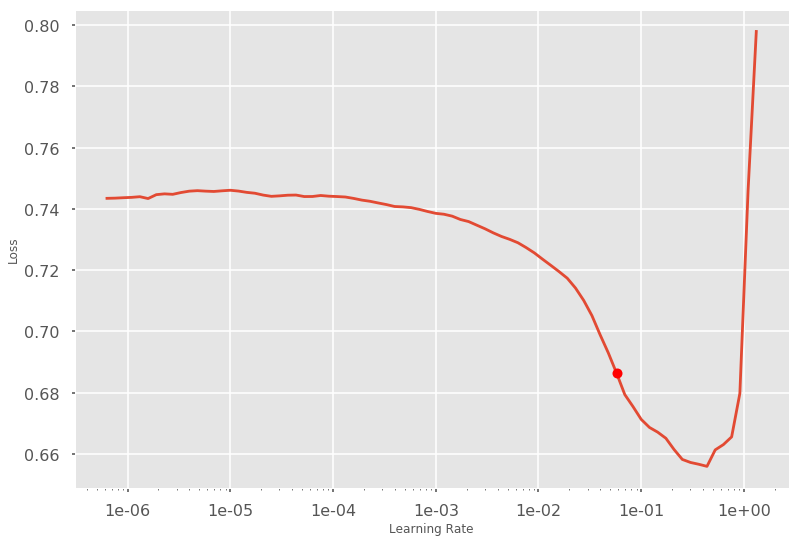

In [54]:
from fastai.callbacks import *

learn_tfidf = tabular_learner(data, 
                              layers=[64, 128], 
                              ps=[0.30, 0.3], 
                              emb_drop=0.10, 
                              callback_fns=ReduceLROnPlateauCallback)

learn_tfidf.crit = Regress_Loss
# learn_tfidf.crit = Regress_Loss_1
learn_tfidf.lr_find()
learn_tfidf.recorder.plot(suggestion=True)

In [55]:
lr = 5e-2
learn_tfidf.fit_one_cycle(30, max_lr=lr,  pct_start=0.3, wd = 1.)

epoch,train_loss,valid_loss,time
0,0.437051,0.388274,00:03
1,0.388942,0.387067,00:03
2,0.384944,0.388049,00:03
3,0.391286,0.399500,00:03
4,0.395385,0.393998,00:03
5,0.402108,0.405697,00:03
6,0.405859,0.412307,00:03
7,0.405794,0.403479,00:03
8,0.405735,0.409085,00:03
9,0.410544,0.402775,00:03


Epoch 2: reducing lr to 0.0028
Epoch 3: reducing lr to 0.004366488747198734
Epoch 4: reducing lr to 0.006033511252801266
Epoch 5: reducing lr to 0.0076
Epoch 6: reducing lr to 0.008877013326971096
Epoch 7: reducing lr to 0.00971052457977236
Epoch 8: reducing lr to 0.010000000000000002
Epoch 9: reducing lr to 0.00994415435450912
Epoch 10: reducing lr to 0.00977786491747459
Epoch 11: reducing lr to 0.009504846320134739
Epoch 12: reducing lr to 0.009131197346804489
Epoch 13: reducing lr to 0.008665264698111696
Epoch 14: reducing lr to 0.008117456539497631
Epoch 15: reducing lr to 0.0075000100000000005
Epoch 16: reducing lr to 0.006826717815011489
Epoch 17: reducing lr to 0.006112620219362893
Epoch 18: reducing lr to 0.0053736689733302504
Epoch 19: reducing lr to 0.00462637102666975
Epoch 20: reducing lr to 0.0038874197806371075
Epoch 21: reducing lr to 0.003173322184988512
Epoch 22: reducing lr to 0.0025000300000000016
Epoch 23: reducing lr to 0.0018825834605023701
Epoch 24: reducing lr t

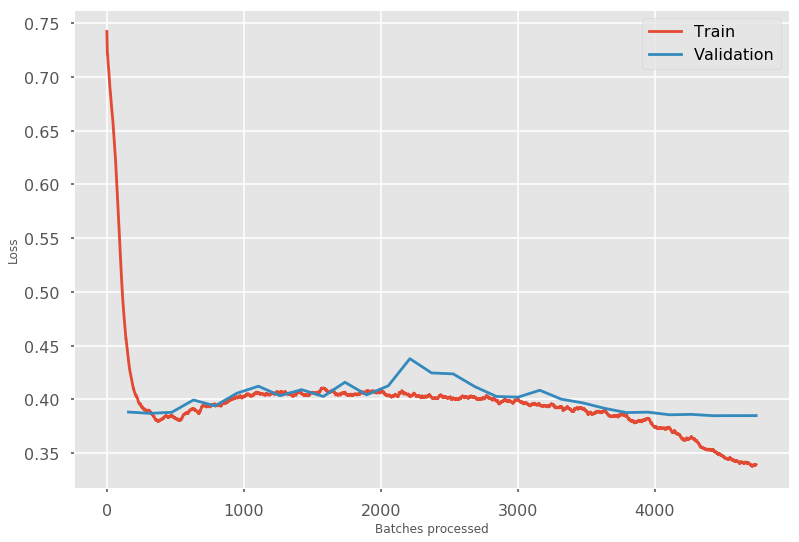

In [56]:
learn_tfidf.recorder.plot_losses()

In [57]:
pred_test_tfidf, lbl_test_tfidf = learn_tfidf.get_preds(ds_type=DatasetType.Test)

In [58]:
pred_test_tfidf = np.clip(pred_test_tfidf, 0.00001, 0.999999)
pred_test_tfidf.shape

torch.Size([476, 30])

In [59]:
pred_test_tfidf

tensor([[0.9175, 0.6890, 0.0792,  ..., 0.0611, 0.8736, 0.9193],
        [0.8750, 0.5329, 0.0089,  ..., 0.1582, 0.1952, 0.8965],
        [0.8980, 0.6199, 0.0287,  ..., 0.0938, 0.7945, 0.9157],
        ...,
        [0.8473, 0.4824, 0.0521,  ..., 0.2155, 0.5264, 0.8924],
        [0.9283, 0.7013, 0.0286,  ..., 0.0497, 0.8000, 0.9279],
        [0.9091, 0.6265, 0.0142,  ..., 0.1197, 0.1507, 0.9092]])

In [60]:
learn_tfidf_2 = tabular_learner(data, 
                              layers=[512, 256], 
                              ps=[0.30, 0.3], 
                              emb_drop=0.10, 
                              callback_fns=ReduceLROnPlateauCallback)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-02
Min loss divided by 10: 3.63E-02


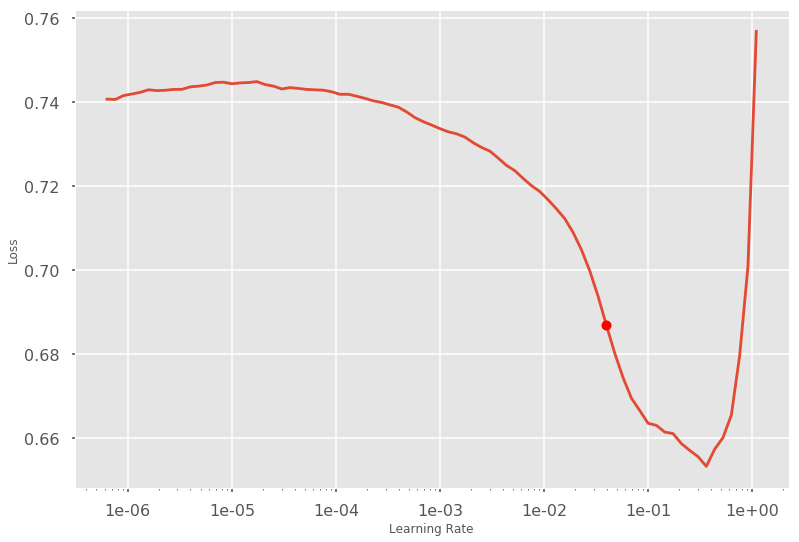

In [61]:
#learn_tfidf.crit = Regress_Loss
learn_tfidf_2.crit = Regress_Loss_1
learn_tfidf_2.lr_find()
learn_tfidf_2.recorder.plot(suggestion=True)

In [62]:
lr = 5e-2
learn_tfidf_2.fit_one_cycle(30, max_lr=lr,  pct_start=0.3, wd = 1.)

epoch,train_loss,valid_loss,time
0,0.419233,0.386047,00:03
1,0.381564,0.380737,00:03
2,0.379133,0.385998,00:03
3,0.385523,0.392008,00:03
4,0.393654,0.400620,00:03
5,0.397849,0.408118,00:03
6,0.401823,0.935876,00:03
7,0.403500,0.415233,00:03
8,0.406927,0.411352,00:03
9,0.403534,0.581282,00:03


Epoch 2: reducing lr to 0.0028
Epoch 3: reducing lr to 0.004366488747198734
Epoch 4: reducing lr to 0.006033511252801266
Epoch 5: reducing lr to 0.0076
Epoch 6: reducing lr to 0.008877013326971096
Epoch 7: reducing lr to 0.00971052457977236
Epoch 8: reducing lr to 0.010000000000000002
Epoch 9: reducing lr to 0.00994415435450912
Epoch 10: reducing lr to 0.00977786491747459
Epoch 11: reducing lr to 0.009504846320134739
Epoch 12: reducing lr to 0.009131197346804489
Epoch 13: reducing lr to 0.008665264698111696
Epoch 14: reducing lr to 0.008117456539497631
Epoch 15: reducing lr to 0.0075000100000000005
Epoch 16: reducing lr to 0.006826717815011489
Epoch 17: reducing lr to 0.006112620219362893
Epoch 18: reducing lr to 0.0053736689733302504
Epoch 19: reducing lr to 0.00462637102666975
Epoch 20: reducing lr to 0.0038874197806371075
Epoch 21: reducing lr to 0.003173322184988512
Epoch 22: reducing lr to 0.0025000300000000016
Epoch 23: reducing lr to 0.0018825834605023701
Epoch 24: reducing lr t

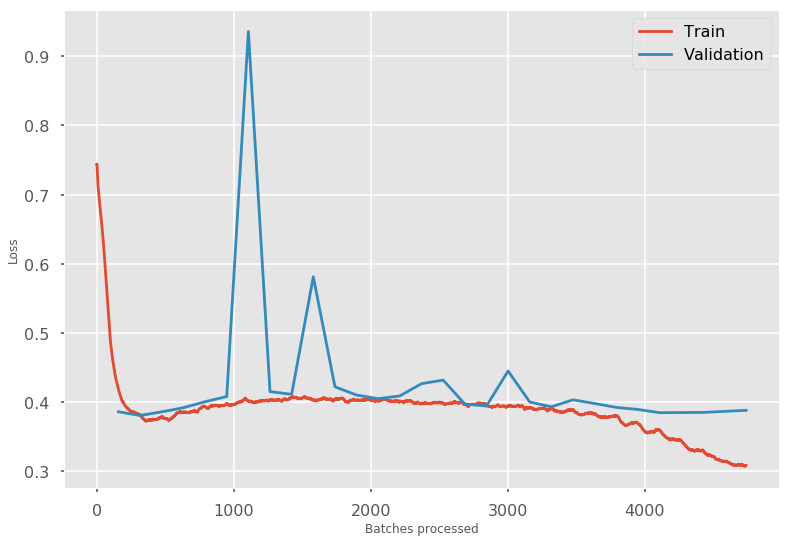

In [63]:
learn_tfidf_2.recorder.plot_losses()

In [64]:
pred_test_tfidf_2, lbl_test_tfidf_2 = learn_tfidf_2.get_preds(ds_type=DatasetType.Test)

In [65]:
pred_test_tfidf_2 = np.clip(pred_test_tfidf_2, 0.00001, 0.999999)
pred_test_tfidf_2.shape

torch.Size([476, 30])

In [66]:
pred_test_tfidf_2

tensor([[0.8996, 0.6944, 0.1009,  ..., 0.0660, 0.9063, 0.9023],
        [0.8728, 0.5094, 0.0065,  ..., 0.1475, 0.1392, 0.8979],
        [0.8908, 0.6398, 0.0374,  ..., 0.0983, 0.7976, 0.8951],
        ...,
        [0.8226, 0.4025, 0.0529,  ..., 0.2586, 0.6248, 0.8955],
        [0.9129, 0.6801, 0.0335,  ..., 0.0772, 0.7936, 0.9276],
        [0.8941, 0.5964, 0.0155,  ..., 0.0925, 0.1215, 0.8929]])

In [67]:
learn_tfidf_3 = tabular_learner(data, 
                              layers=[512], 
                              ps=[0.30], 
                              emb_drop=0.10, 
                              callback_fns=ReduceLROnPlateauCallback)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-02
Min loss divided by 10: 1.20E-02


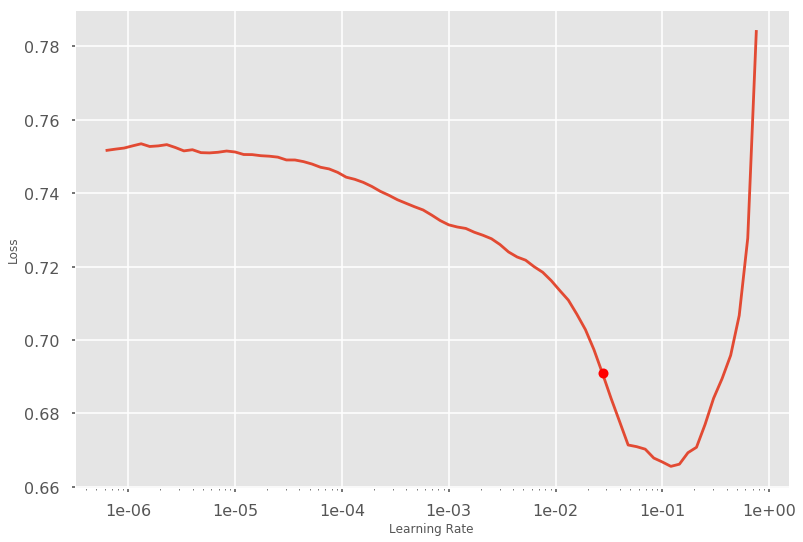

In [68]:
#learn_tfidf.crit = Regress_Loss
learn_tfidf_3.crit = Regress_Loss_1
learn_tfidf_3.lr_find()
learn_tfidf_3.recorder.plot(suggestion=True)

In [69]:
lr = 3e-2
learn_tfidf_3.fit_one_cycle(30, max_lr=lr,  pct_start=0.3, wd = 1.)

epoch,train_loss,valid_loss,time
0,0.434279,0.388448,00:03
1,0.380225,0.378940,00:03
2,0.367926,0.381112,00:03
3,0.372156,0.392970,00:03
4,0.379146,0.395619,00:03
5,0.386362,0.397813,00:03
6,0.390068,0.399663,00:03
7,0.391562,0.420318,00:03
8,0.395680,0.413485,00:03
9,0.394681,0.398913,00:03


Epoch 2: reducing lr to 0.0016799999999999996
Epoch 3: reducing lr to 0.00261989324831924
Epoch 4: reducing lr to 0.003620106751680759
Epoch 5: reducing lr to 0.004559999999999999
Epoch 6: reducing lr to 0.005326207996182657
Epoch 7: reducing lr to 0.005826314747863416
Epoch 8: reducing lr to 0.006
Epoch 9: reducing lr to 0.00596649261270547
Epoch 10: reducing lr to 0.005866718950484753
Epoch 11: reducing lr to 0.005702907792080842
Epoch 12: reducing lr to 0.005478718408082693
Epoch 13: reducing lr to 0.005199158818867017
Epoch 14: reducing lr to 0.004870473923698579
Epoch 15: reducing lr to 0.004500006
Epoch 16: reducing lr to 0.004096030689006893
Epoch 17: reducing lr to 0.003667572131617736
Epoch 18: reducing lr to 0.0032242013839981504
Epoch 19: reducing lr to 0.0027758226160018505
Epoch 20: reducing lr to 0.0023324518683822642
Epoch 21: reducing lr to 0.001903993310993107
Epoch 22: reducing lr to 0.0015000180000000007
Epoch 23: reducing lr to 0.001129550076301422
Epoch 24: reducin

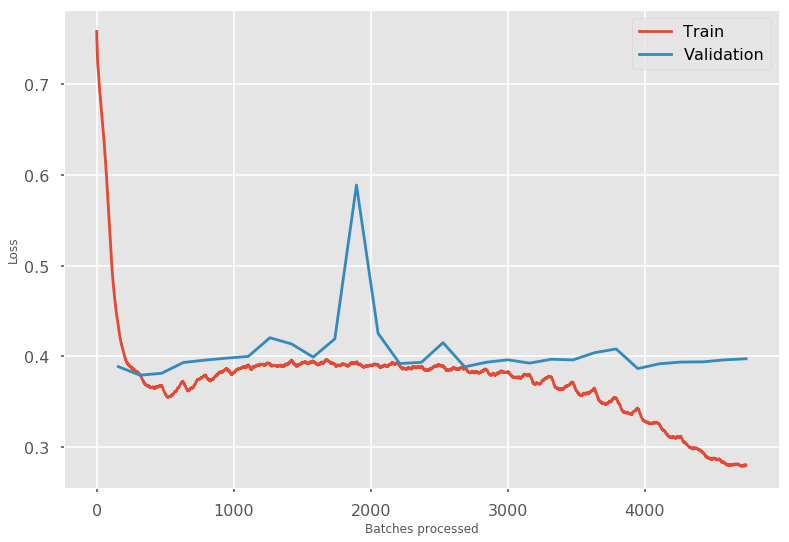

In [70]:
learn_tfidf_3.recorder.plot_losses()

In [71]:
pred_test_tfidf_3, lbl_test_tfidf_3 = learn_tfidf_3.get_preds(ds_type=DatasetType.Test)

In [72]:
pred_test_tfidf_3 = np.clip(pred_test_tfidf_3, 0.00001, 0.999999)
pred_test_tfidf_3.shape

torch.Size([476, 30])

In [73]:
pred_test_tfidf_3

tensor([[0.9236, 0.7444, 0.1021,  ..., 0.0477, 0.9807, 0.9048],
        [0.8895, 0.5009, 0.0038,  ..., 0.0876, 0.0816, 0.9086],
        [0.9004, 0.6771, 0.0139,  ..., 0.0514, 0.8359, 0.9025],
        ...,
        [0.8625, 0.4759, 0.0210,  ..., 0.1066, 0.6318, 0.9072],
        [0.9336, 0.7584, 0.0405,  ..., 0.0495, 0.8675, 0.9433],
        [0.9175, 0.6204, 0.0083,  ..., 0.0396, 0.1303, 0.9171]])

In [74]:
test_preds_fastai = (pred_test_tfidf+ pred_test_tfidf_2 + pred_test_tfidf_3)/3

In [75]:
test_preds_fastai

tensor([[0.9135, 0.7092, 0.0941,  ..., 0.0583, 0.9202, 0.9088],
        [0.8791, 0.5144, 0.0064,  ..., 0.1311, 0.1387, 0.9010],
        [0.8964, 0.6456, 0.0267,  ..., 0.0811, 0.8093, 0.9044],
        ...,
        [0.8441, 0.4536, 0.0420,  ..., 0.1936, 0.5943, 0.8984],
        [0.9249, 0.7133, 0.0342,  ..., 0.0588, 0.8204, 0.9329],
        [0.9069, 0.6144, 0.0127,  ..., 0.0839, 0.1342, 0.9064]])

In [76]:
submission = pd.read_csv(INPUT_PATH+'google-quest-challenge/sample_submission.csv')
submission[targets] = test_preds_fastai
submission.head(20)

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.913543,0.709236,0.094071,0.696799,0.850042,0.751481,0.642731,0.593982,0.174425,0.005313,0.415845,0.378639,0.025124,0.031440,0.023951,0.023888,0.057530,0.081275,0.772249,0.001828,0.896051,0.855021,0.614727,0.932059,0.930740,0.780368,0.032311,0.058289,0.920210,0.908810
1,46,0.879124,0.514382,0.006434,0.778852,0.833262,0.936608,0.549244,0.451476,0.155502,0.004365,0.448814,0.324582,0.005718,0.004106,0.003010,0.019708,0.890135,0.179228,0.081492,0.000831,0.741315,0.947062,0.647173,0.972427,0.978120,0.867479,0.890052,0.131115,0.138653,0.900995
2,70,0.896408,0.645595,0.026652,0.783349,0.873377,0.908836,0.589749,0.495781,0.257672,0.004157,0.356065,0.548081,0.027538,0.019138,0.012999,0.030124,0.214546,0.092905,0.512444,0.002137,0.836985,0.916719,0.632114,0.959331,0.963166,0.833731,0.148350,0.081133,0.809318,0.904432
3,132,0.848312,0.442263,0.017839,0.712354,0.810732,0.902024,0.559694,0.469240,0.216243,0.009692,0.508844,0.114448,0.013449,0.008724,0.012796,0.010706,0.676393,0.150865,0.624262,0.001398,0.709180,0.938508,0.654228,0.966652,0.973323,0.855970,0.703891,0.125707,0.706471,0.896396
4,200,0.891681,0.576870,0.041960,0.589976,0.878839,0.683330,0.621158,0.599558,0.159242,0.007397,0.359189,0.188351,0.036446,0.019058,0.032518,0.069832,0.286088,0.150301,0.280398,0.002904,0.833601,0.893216,0.629519,0.940669,0.951041,0.811705,0.320638,0.123332,0.335915,0.895681
5,245,0.896376,0.698151,0.038578,0.631030,0.909579,0.873344,0.607142,0.512669,0.195713,0.006034,0.250797,0.049604,0.028859,0.014048,0.033007,0.038763,0.198671,0.131915,0.699926,0.001770,0.853601,0.898221,0.623885,0.946747,0.955249,0.819447,0.148379,0.097261,0.733997,0.888862
6,257,0.855714,0.497761,0.012527,0.702447,0.786950,0.854807,0.543496,0.450600,0.184079,0.008254,0.545550,0.111550,0.016539,0.005478,0.006932,0.047579,0.893222,0.269154,0.094688,0.001385,0.723752,0.935708,0.655754,0.963687,0.971840,0.851732,0.876226,0.210451,0.171092,0.892163
7,267,0.943119,0.738337,0.131589,0.725093,0.833758,0.754174,0.661139,0.649979,0.174187,0.003578,0.397345,0.144592,0.047476,0.024131,0.066590,0.027060,0.013431,0.028077,0.881158,0.002042,0.903599,0.924501,0.655119,0.965622,0.970937,0.851552,0.013774,0.025243,0.937844,0.924537
8,284,0.849564,0.423642,0.014285,0.606745,0.798753,0.836469,0.547593,0.452565,0.148932,0.007543,0.582627,0.071809,0.009616,0.005427,0.003929,0.014248,0.805038,0.219840,0.388022,0.000690,0.718322,0.950375,0.652754,0.974544,0.978441,0.867983,0.705092,0.170695,0.640716,0.909414
9,292,0.898168,0.599017,0.009736,0.736291,0.891901,0.938534,0.593562,0.490460,0.175395,0.004645,0.363342,0.055413,0.006822,0.005984,0.004154,0.009056,0.716118,0.135485,0.679558,0.000551,0.801017,0.941297,0.632597,0.973974,0.975287,0.850806,0.537006,0.100573,0.817463,0.905840


In [77]:
submission.to_csv("submission.csv", index = False)

# K fold

In [78]:
data_init = data

In [79]:
x = int(len(norm_data_train)*.9)
train_df = norm_data_train.iloc[:x]
test_df = norm_data_train.iloc[x:]

In [80]:
skf = KFold(n_splits=10, shuffle=True, random_state=42)
for train_index, test_index in skf.split(norm_data_train.index):
    
    X_train, X_test = norm_data_train.iloc[train_index], norm_data_train.iloc[test_index]
    y_train, y_test = norm_data_train[targets].iloc[train_index], norm_data_train[targets].iloc[test_index]    

In [81]:
X_train.head()

,0_col,1_col,2_col,3_col,4_col,5_col,6_col,7_col,8_col,9_col,10_col,11_col,12_col,13_col,14_col,15_col,16_col,17_col,18_col,19_col,20_col,21_col,22_col,23_col,24_col,25_col,26_col,27_col,28_col,29_col,30_col,31_col,32_col,33_col,34_col,35_col,36_col,37_col,38_col,39_col,40_col,41_col,42_col,43_col,44_col,45_col,46_col,47_col,48_col,49_col,50_col,51_col,52_col,53_col,54_col,55_col,56_col,57_col,58_col,59_col,60_col,61_col,62_col,63_col,64_col,65_col,66_col,67_col,68_col,69_col,70_col,71_col,72_col,73_col,74_col,75_col,76_col,77_col,78_col,79_col,80_col,81_col,82_col,83_col,84_col,85_col,86_col,87_col,88_col,89_col,90_col,91_col,92_col,93_col,94_col,95_col,96_col,97_col,98_col,99_col,100_col,101_col,102_col,103_col,104_col,105_col,106_col,107_col,108_col,109_col,110_col,111_col,112_col,113_col,114_col,115_col,116_col,117_col,118_col,119_col,120_col,121_col,122_col,123_col,124_col,125_col,126_col,127_col,128_col,129_col,130_col,131_col,132_col,133_col,134_col,135_col,136_col,137_col,138_col,139_col,140_col,141_col,142_col,143_col,144_col,145_col,146_col,147_col,148_col,149_col,150_col,151_col,152_col,153_col,154_col,155_col,156_col,157_col,158_col,159_col,160_col,161_col,162_col,163_col,164_col,165_col,166_col,167_col,168_col,169_col,170_col,171_col,172_col,173_col,174_col,175_col,176_col,177_col,178_col,179_col,180_col,181_col,182_col,183_col,184_col,185_col,186_col,187_col,188_col,189_col,190_col,191_col,192_col,193_col,194_col,195_col,196_col,197_col,198_col,199_col,200_col,201_col,202_col,203_col,204_col,205_col,206_col,207_col,208_col,209_col,210_col,211_col,212_col,213_col,214_col,215_col,216_col,217_col,218_col,219_col,220_col,221_col,222_col,223_col,224_col,225_col,226_col,227_col,228_col,229_col,230_col,231_col,232_col,233_col,234_col,235_col,236_col,237_col,238_col,239_col,240_col,241_col,242_col,243_col,244_col,245_col,246_col,247_col,248_col,249_col,...,3037_col,3038_col,3039_col,3040_col,3041_col,3042_col,3043_col,3044_col,3045_col,3046_col,3047_col,3048_col,3049_col,3050_col,3051_col,3052_col,3053_col,3054_col,3055_col,3056_col,3057_col,3058_col,3059_col,3060_col,3061_col,3062_col,3063_col,3064_col,3065_col,3066_col,3067_col,3068_col,3069_col,3070_col,3071_col,3072_col,3073_col,3074_col,3075_col,3076_col,3077_col,3078_col,3079_col,3080_col,3081_col,3082_col,3083_col,3084_col,3085_col,3086_col,3087_col,3088_col,3089_col,3090_col,3091_col,3092_col,3093_col,3094_col,3095_col,3096_col,3097_col,3098_col,3099_col,3100_col,3101_col,3102_col,3103_col,3104_col,3105_col,3106_col,3107_col,3108_col,3109_col,3110_col,3111_col,3112_col,3113_col,3114_col,3115_col,3116_col,3117_col,3118_col,3119_col,3120_col,3121_col,3122_col,3123_col,3124_col,3125_col,3126_col,3127_col,3128_col,3129_col,3130_col,3131_col,3132_col,3133_col,3134_col,3135_col,3136_col,3137_col,3138_col,3139_col,3140_col,3141_col,3142_col,3143_col,3144_col,3145_col,3146_col,3147_col,3148_col,3149_col,3150_col,3151_col,3152_col,3153_col,3154_col,3155_col,3156_col,3157_col,3158_col,3159_col,3160_col,3161_col,3162_col,3163_col,3164_col,3165_col,3166_col,3167_col,3168_col,3169_col,3170_col,3171_col,3172_col,3173_col,3174_col,3175_col,3176_col,3177_col,3178_col,3179_col,3180_col,3181_col,3182_col,3183_col,3184_col,3185_col,3186_col,3187_col,3188_col,3189_col,3190_col,3191_col,3192_col,3193_col,3194_col,3195_col,3196_col,3197_col,3198_col,3199_col,3200_col,3201_col,3202_col,3203_col,3204_col,3205_col,3206_col,3207_col,3208_col,3209_col,3210_col,3211_col,3212_col,3213_col,3214_col,3215_col,3216_col,3217_col,3218_col,3219_col,3220_col,3221_col,3222_col,3223_col,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_en

In [82]:

val_pct = []
test_pct = []


for train_index, val_index in skf.split(train_df.index, train_df[dep_var]):
    data_fold = (TabularList.from_df(train_df, cat_names=cat_names.copy(),
                                  cont_names=cont_names.copy(), procs=procs,
                                  processor=data_init.processor) # Very important
              .split_by_idxs(train_index, val_index)
              .label_from_df(cols=dep_var)
              .databunch())
    
    data_test = (TabularList.from_df(test_df, cat_names=cat_names.copy(),
                                  cont_names=cont_names.copy(), procs=procs,
                                  processor=data_init.processor) # Very important
              .split_none()
              .label_from_df(cols=dep_var))
    
    data_test.valid = data_test.train
    data_test = data_test.databunch()
    
    learn_f = tabular_learner(data_fold, layers=[200, 100], 
                        ps=[0.3, 0.3], emb_drop=0.3)
    
    learn_f.fit_one_cycle(10, max_lr=1e-3,  pct_start=0.5, wd = 1, callbacks = [SaveModelCallback(learn_f)])
    
    val = learn_f.validate()
    
    learn_f.data.valid_dl = data_test.valid_dl
    
    test = learn_f.validate()
    
    val_pct.append(val)
    test_pct.append(test)

In [83]:
print(f'Validation\nmean: {np.mean(val_pct)}\nstd: {np.std(val_pct)}')

Validation
mean: 0.3742212653160095
std: 0.002442586235702038


In [84]:
print(f'Test\nmean: {np.mean(test_pct)}\nstd: {np.std(test_pct)}')

Test
mean: 0.37538206577301025
std: 0.0007224826840683818


In [85]:
data = (TabularList.from_df(norm_data_train, procs = procs, cont_names=cont_names, cat_names=cat_names)
        .split_by_idx(valid_idx)
        .label_from_df(cols=dep_var)
        .add_test(test_tab)
        .databunch(bs=32))

In [86]:
learn_f = tabular_learner(data, layers=[200, 100], 
                        ps=[0.3, 0.3], emb_drop=0.3)
learn_f.load('bestmodel')

Learner(data=TabularDataBunch;

Train: LabelList (5079 items)
x: TabularList
question_user_name ysap; answer_user_name rfusca; netloc_1 photo; netloc_2 photo; netloc_3 photo; category LIFE_ARTS; host photo.stackexchange.com; is_question_no_name_user 0; is_answer_no_name_user 0; dom_cnt 3; dom_0 photo; dom_1 stackexchange; dom_2 com; dom_3 none; question_title_num_stopwords 6; question_body_num_stopwords 59; answer_num_stopwords 76; question_title_num_punctuations 1; question_body_num_punctuations 42; answer_num_punctuations 44; question_title_num_words_upper 0; question_body_num_words_upper 0; answer_num_words_upper 0; 0_col 1.1832; 1_col 2.0184; 2_col 1.0514; 3_col -0.6366; 4_col 0.0204; 5_col 0.7661; 6_col -0.3452; 7_col -0.8528; 8_col -1.1621; 9_col -1.1206; 10_col 0.8552; 11_col 0.9243; 12_col 0.2792; 13_col 0.3630; 14_col 0.0310; 15_col 0.5414; 16_col 1.3548; 17_col -0.0171; 18_col -1.5262; 19_col 2.0643; 20_col 0.0965; 21_col -0.4956; 22_col 1.4638; 23_col 0.7130; 24_col -1.2099;

In [87]:
learn_f.fit_one_cycle(10, max_lr=1e-3,  pct_start=0.5, wd = 1)

epoch,train_loss,valid_loss,time
0,0.357679,0.364404,00:03
1,0.356744,0.365984,00:03
2,0.358444,0.369482,00:03
3,0.358720,0.371942,00:03
4,0.353964,0.373161,00:03
5,0.348011,0.374498,00:03
6,0.340646,0.375442,00:03
7,0.333454,0.374608,00:03
8,0.326841,0.375065,00:03
9,0.322466,0.375055,00:03


In [88]:
pred_test_tfidf, lbl_test_tfidf = learn_f.get_preds(ds_type=DatasetType.Test)

In [89]:
pred_test_tfidf = np.clip(pred_test_tfidf, 0.00001, 0.999999)
pred_test_tfidf.shape

torch.Size([476, 30])

In [90]:
pred_test_tfidf

tensor([[0.9018, 0.6448, 0.0638,  ..., 0.0648, 0.8931, 0.9087],
        [0.8666, 0.4826, 0.0057,  ..., 0.1618, 0.0976, 0.8905],
        [0.9084, 0.6592, 0.0140,  ..., 0.1207, 0.7234, 0.9135],
        ...,
        [0.8320, 0.3688, 0.0444,  ..., 0.2391, 0.7089, 0.9001],
        [0.8924, 0.6724, 0.0171,  ..., 0.0843, 0.7970, 0.9107],
        [0.8531, 0.5610, 0.0121,  ..., 0.1207, 0.2475, 0.8594]])

In [91]:
submission = pd.read_csv(INPUT_PATH+'google-quest-challenge/sample_submission.csv')
submission[targets] = pred_test_tfidf
submission.head(20)

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.901826,0.644774,0.063765,0.794346,0.790910,0.881577,0.602740,0.536301,0.224783,0.005202,0.443374,0.700320,0.022342,0.028532,0.020046,0.019323,0.114590,0.074716,0.699100,0.002913,0.841808,0.914288,0.639864,0.957407,0.960909,0.835953,0.082407,0.064771,0.893122,0.908715
1,46,0.866551,0.482628,0.005693,0.714214,0.838286,0.935616,0.541701,0.444541,0.295700,0.004848,0.450658,0.529451,0.006811,0.005370,0.003446,0.016206,0.912540,0.228023,0.094028,0.001123,0.738596,0.938663,0.640503,0.964039,0.975612,0.863544,0.935027,0.161824,0.097626,0.890516
2,70,0.908442,0.659197,0.014009,0.747803,0.943693,0.937130,0.603639,0.527568,0.381051,0.002496,0.196765,0.756038,0.027370,0.021755,0.016811,0.024764,0.225408,0.147360,0.427751,0.002408,0.870024,0.917274,0.632873,0.957307,0.964253,0.838497,0.148585,0.120745,0.723378,0.913492
3,132,0.815365,0.417106,0.012020,0.683577,0.851476,0.943968,0.528059,0.410889,0.254598,0.013627,0.420393,0.145999,0.015190,0.011412,0.010711,0.010577,0.809566,0.223033,0.668232,0.002263,0.662544,0.929826,0.639009,0.960455,0.966908,0.844344,0.824638,0.179541,0.663443,0.870731
4,200,0.894317,0.551676,0.026318,0.759322,0.782629,0.871852,0.593131,0.524917,0.292039,0.007220,0.521388,0.598546,0.027353,0.019440,0.013230,0.029252,0.552065,0.225707,0.310574,0.002772,0.792466,0.936795,0.666813,0.966380,0.969079,0.861276,0.467720,0.200149,0.659812,0.908581
5,245,0.894584,0.698905,0.024861,0.595495,0.952973,0.871867,0.606639,0.539184,0.260732,0.004526,0.168816,0.075144,0.050746,0.018438,0.041759,0.056493,0.225038,0.215452,0.628549,0.002759,0.863340,0.904881,0.648528,0.946205,0.957099,0.832514,0.151873,0.177414,0.782687,0.894663
6,257,0.858457,0.483851,0.013151,0.636093,0.815554,0.857744,0.550169,0.454086,0.291274,0.009079,0.510676,0.190392,0.017749,0.009142,0.008219,0.047561,0.886670,0.342858,0.156672,0.001951,0.731348,0.933000,0.660635,0.960333,0.968180,0.855459,0.864415,0.280623,0.280422,0.887971
7,267,0.930379,0.730019,0.189599,0.643567,0.790058,0.672692,0.656224,0.649236,0.244595,0.004510,0.477008,0.223491,0.039285,0.026100,0.078900,0.015746,0.023433,0.041355,0.930483,0.003034,0.892486,0.909340,0.648509,0.957875,0.962551,0.834303,0.024214,0.034329,0.957868,0.914429
8,284,0.802583,0.422060,0.022625,0.391096,0.918261,0.801259,0.556025,0.455786,0.324433,0.009847,0.332327,0.056303,0.019354,0.014427,0.022269,0.048505,0.634200,0.449975,0.617744,0.002254,0.738029,0.911917,0.650086,0.945612,0.957666,0.833045,0.516196,0.367578,0.750812,0.881764
9,292,0.867184,0.604439,0.014292,0.474402,0.967370,0.886989,0.591430,0.501821,0.462615,0.004748,0.169316,0.091691,0.031019,0.016373,0.022575,0.037954,0.427595,0.275693,0.766378,0.002115,0.837848,0.897732,0.617916,0.944496,0.952432,0.808425,0.302131,0.218112,0.819145,0.884583


In [92]:
submission.to_csv("submission.csv", index = False)

# Keras

In [93]:
# import os
# import re
# import gc
# import pickle  
# import random
# import keras

# import numpy as np
# import pandas as pd
# import tensorflow as tf
# import tensorflow_hub as hub
# import keras.backend as K

# from keras.models import Model
# from keras.layers import Dense, Input, Dropout, Lambda
# from keras.optimizers import Adam
# from keras.callbacks import Callback
# from scipy.stats import spearmanr, rankdata
# from os.path import join as path_join
# from numpy.random import seed
# from urllib.parse import urlparse
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.model_selection import KFold
# from sklearn.linear_model import MultiTaskElasticNet
# from sklearn.multioutput import MultiOutputRegressor
# from lightgbm import LGBMRegressor

# seed(42)
# tf.random.set_seed(42)
# random.seed(42)

In [94]:
# # Categorical boolean mask
# categorical_feature_mask = norm_data_train.dtypes=='object'
# # filter categorical columns using mask and turn it into a list
# categorical_cols = norm_data_train.columns[categorical_feature_mask].tolist()
# categorical_cols

In [95]:
# type(norm_data_train.question_user_name[0])

In [96]:
# # Categorical boolean mask
# categorical_feature_mask = norm_data_train.dtypes=='object'
# # filter categorical columns using mask and turn it into a list
# categorical_cols = norm_data_train.columns[categorical_feature_mask].tolist()

# # import labelencoder
# from sklearn.preprocessing import LabelEncoder
# # instantiate labelencoder object
# le = LabelEncoder()

# # apply le on categorical feature columns
# norm_data_train[categorical_cols] = norm_data_train[categorical_cols].apply(lambda col: le.fit_transform(col))
# norm_data_train[categorical_cols].head(10)


In [97]:
# # Categorical boolean mask
# categorical_feature_mask = norm_data_test.dtypes=='object'
# # filter categorical columns using mask and turn it into a list
# categorical_cols = norm_data_test.columns[categorical_feature_mask].tolist()

# # import labelencoder
# from sklearn.preprocessing import LabelEncoder
# # instantiate labelencoder object
# le = LabelEncoder()

# # apply le on categorical feature columns
# norm_data_test[categorical_cols] = norm_data_test[categorical_cols].apply(lambda col: le.fit_transform(col))
# norm_data_test[categorical_cols].head(10)

In [98]:
# X_train = norm_data_train.loc[:, ~norm_data_train.columns.isin(targets)].values
# y_train = norm_data_train[targets].values
# X_test = norm_data_test.values

In [99]:
# X_train.shape, y_train.shape, X_test.shape

In [100]:
# norm_data_train.head()

In [101]:
# # Compatible with tensorflow backend
# class SpearmanRhoCallback(Callback):
#     def __init__(self, training_data, validation_data, patience, model_name):
#         self.x = training_data[0]
#         self.y = training_data[1]
#         self.x_val = validation_data[0]
#         self.y_val = validation_data[1]
        
#         self.patience = patience
#         self.value = -1
#         self.bad_epochs = 0
#         self.model_name = model_name

#     def on_train_begin(self, logs={}):
#         return

#     def on_train_end(self, logs={}):
#         return

#     def on_epoch_begin(self, epoch, logs={}):
#         return

#     def on_epoch_end(self, epoch, logs={}):
#         y_pred_val = self.model.predict(self.x_val)
#         rho_val = np.mean([spearmanr(self.y_val[:, ind], y_pred_val[:, ind] + np.random.normal(0, 1e-7, y_pred_val.shape[0])).correlation for ind in range(y_pred_val.shape[1])])
#         if rho_val >= self.value:
#             self.value = rho_val
#         else:
#             self.bad_epochs += 1
#         if self.bad_epochs >= self.patience:
#             print("Epoch %05d: early stopping Threshold" % epoch)
#             self.model.stop_training = True
#             #self.model.save_weights(self.model_name)
#         print('\rval_spearman-rho: %s' % (str(round(rho_val, 4))), end=100*' '+'\n')
#         return rho_val

#     def on_batch_begin(self, batch, logs={}):
#         return

#     def on_batch_end(self, batch, logs={}):
#         return

In [102]:
# from keras.losses import *
# def bce(t,p):
#     return binary_crossentropy(t,p)

# def custom_loss(true,pred):
#     bce = binary_crossentropy(true,pred)
#     return bce + logcosh(true,pred)

# def swish(x):
#     return K.sigmoid(x) * x

# def relu1(x):
#     return keras.activations.relu(x, alpha=0.0, max_value=1., threshold=0.0)

# def create_model1():
#     input1 = Input(shape=(X_train.shape[1],))
#     x = Dense(64, activation='elu',kernel_initializer='lecun_normal')(input1)
#     x = Dense(128, activation='elu',kernel_initializer='lecun_normal')(x)
#     x = Dropout(0.4)(x)
#     output = Dense(len(targets),activation='sigmoid',name='output')(x)
#     model = Model(inputs=input1, outputs=output)
#     optimizer = Adam(lr=5e-4,clipnorm=1.4)
#     model.compile(optimizer=optimizer, loss=custom_loss, metrics=[bce,logcosh])
#     return model


# def create_model2():
#     input1 = Input(shape=(X_train.shape[1],))
#     x = Dense(512, activation='elu',kernel_initializer='lecun_normal')(input1)
#     x = Dense(256, activation='elu',
#               kernel_initializer='lecun_normal', 
#               #kernel_regularizer=keras.regularizers.l2(0.01)
#              )(x)
#     output = Dense(len(targets),activation='sigmoid',name='output')(x)
#     model = Model(inputs=input1, outputs=output)
#     optimizer = Adam(lr=5e-4,clipnorm=1.4)
#     model.compile(optimizer=optimizer, loss=custom_loss, metrics=[bce,logcosh])
#     return model


# def create_model3():
#     input1 = Input(shape=(X_train.shape[1],))
#     x = Dense(200, activation='selu',kernel_initializer='lecun_normal')(input1)
#     x = Dense(512, activation='selu',
#               kernel_initializer='lecun_normal', 
#               )(x)
#     x = Dropout(0.4)(x)
#     output = Dense(len(targets),activation='sigmoid',name='output')(x)
#     model = Model(inputs=input1, outputs=output)
#     optimizer = Adam(lr=5e-4,clipnorm=1.4)
#     model.compile(optimizer=optimizer, loss=custom_loss, metrics=[bce,logcosh])
#     return model

# def create_model4():
#     input1 = Input(shape=(X_train.shape[1],))
#     x = Dense(512, activation='elu',
#               kernel_initializer='lecun_normal', 
#               )(input1)
#     x = Dropout(0.2)(x)
#     output = Dense(len(targets),activation='sigmoid',name='output')(x)
#     model = Model(inputs=input1, outputs=output)
#     optimizer = Adam(lr=5e-4,clipnorm=1.4)
#     model.compile(optimizer=optimizer, loss=custom_loss, metrics=[bce,logcosh])
#     return model

# def create_model5():
#     input1 = Input(shape=(X_train.shape[1],))
#     x = Dense(4096, activation='selu',kernel_initializer='lecun_normal')(input1)
#     x = Dense(512, activation='selu',
#               kernel_initializer='lecun_normal', 
#               kernel_regularizer=keras.regularizers.l2(0.01)
#              )(x)
#     output = Dense(len(targets),activation='sigmoid',name='output')(x)
#     model = Model(inputs=input1, outputs=output)
#     optimizer = Adam(lr=5e-4,clipnorm=1.4)
#     model.compile(optimizer=optimizer, loss=custom_loss, metrics=[bce,logcosh])
#     return model

In [103]:
# all_predictions = []

# kf = KFold(n_splits=5, random_state=42, shuffle=True)
# for ind, (tr, val) in enumerate(kf.split(X_train)):
#     X_tr = X_train[tr]
#     y_tr = y_train[tr]
#     X_vl = X_train[val]
#     y_vl = y_train[val]
    
#     model = create_model1()
#     model.fit(
#         X_tr, y_tr, epochs=100, batch_size=32, validation_data=(X_vl, y_vl), verbose=True, 
#         callbacks=[SpearmanRhoCallback(training_data=(X_tr, y_tr), validation_data=(X_vl, y_vl),
#                                        patience=5, model_name=f'best_model_batch{ind}.h5')]
#     )
#     all_predictions.append(model.predict(X_test))
    
# model = create_model1()
# model.fit(X_train, y_train, epochs=33, batch_size=32, verbose=False)
# all_predictions.append(model.predict(X_test))
    
# kf = KFold(n_splits=5, random_state=2019, shuffle=True)
# for ind, (tr, val) in enumerate(kf.split(X_train)):
#     X_tr = X_train[tr]
#     y_tr = y_train[tr]
#     X_vl = X_train[val]
#     y_vl = y_train[val]
    
#     model = create_model2()
#     model.fit(
#         X_tr, y_tr, epochs=100, batch_size=32, validation_data=(X_vl, y_vl), verbose=True, 
#         callbacks=[SpearmanRhoCallback(training_data=(X_tr, y_tr), validation_data=(X_vl, y_vl),
#                                        patience=5, model_name=f'best_model_batch{ind}.h5')]
#     )
#     all_predictions.append(model.predict(X_test))
    
# model = create_model2()
# model.fit(X_train, y_train, epochs=33, batch_size=32, verbose=False)
# all_predictions.append(model.predict(X_test))

# kf = KFold(n_splits=5, random_state=2019, shuffle=True)
# for ind, (tr, val) in enumerate(kf.split(X_train)):
#     X_tr = X_train[tr]
#     y_tr = y_train[tr]
#     X_vl = X_train[val]
#     y_vl = y_train[val]
    
#     model = create_model3()
#     model.fit(
#         X_tr, y_tr, epochs=100, batch_size=32, validation_data=(X_vl, y_vl), verbose=True, 
#         callbacks=[SpearmanRhoCallback(training_data=(X_tr, y_tr), validation_data=(X_vl, y_vl),
#                                        patience=5, model_name=f'best_model_batch{ind}.h5')]
#     )
#     all_predictions.append(model.predict(X_test))
    
# model = create_model3()
# model.fit(X_train, y_train, epochs=33, batch_size=32, verbose=False)
# all_predictions.append(model.predict(X_test))

# kf = KFold(n_splits=5, random_state=2019, shuffle=True)
# for ind, (tr, val) in enumerate(kf.split(X_train)):
#     X_tr = X_train[tr]
#     y_tr = y_train[tr]
#     X_vl = X_train[val]
#     y_vl = y_train[val]
    
#     model = create_model4()
#     model.fit(
#         X_tr, y_tr, epochs=100, batch_size=32, validation_data=(X_vl, y_vl), verbose=True, 
#         callbacks=[SpearmanRhoCallback(training_data=(X_tr, y_tr), validation_data=(X_vl, y_vl),
#                                        patience=5, model_name=f'best_model_batch{ind}.h5')]
#     )
#     all_predictions.append(model.predict(X_test))
    
# model = create_model4()
# model.fit(X_train, y_train, epochs=33, batch_size=32, verbose=False)
# all_predictions.append(model.predict(X_test))

# kf = KFold(n_splits=5, random_state=2019, shuffle=True)
# for ind, (tr, val) in enumerate(kf.split(X_train)):
#     X_tr = X_train[tr]
#     y_tr = y_train[tr]
#     X_vl = X_train[val]
#     y_vl = y_train[val]
    
#     model = create_model5()
#     model.fit(
#         X_tr, y_tr, epochs=100, batch_size=32, validation_data=(X_vl, y_vl), verbose=True, 
#         callbacks=[SpearmanRhoCallback(training_data=(X_tr, y_tr), validation_data=(X_vl, y_vl),
#                                        patience=5, model_name=f'best_model_batch{ind}.h5')]
#     )
#     all_predictions.append(model.predict(X_test))
    
# model = create_model5()
# model.fit(X_train, y_train, epochs=33, batch_size=32, verbose=False)
# all_predictions.append(model.predict(X_test))

In [104]:
# test_preds = np.array([np.array([rankdata(c) for c in p.T]).T for p in all_predictions]).mean(axis=0)
# max_val = test_preds.max() + 1
# test_preds = test_preds/max_val + 1e-12

In [105]:
# submission = pd.read_csv(INPUT_PATH+'google-quest-challenge/sample_submission.csv')
# submission[targets] = test_preds
# submission.head(20)

In [106]:
# submission.to_csv("submission.csv", index = False)